### Final Project

This project contains several algorithms to solve a Wordle puzzle in as few steps as possible. The notebook is set up in such a way that new strategies can be made by the user, and it also provideds tools for comparing the performance between them.

### Setup

In [3]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import re

Get all of the valid guesses and answers that are used in the real game. They were found <a href=https://github.com/3b1b/videos/tree/master/_2022/wordle/data>here</a>.

In [4]:
valid_guesses = []
with open("possible_guesses.txt", "r") as f:
    valid_guesses = f.read().split("\n")
    
with open("possible_answers.txt", "r") as f:
    answers_no_split = f.read()
    answers = answers_no_split.split("\n")
    answers_no_split = "\n"+answers_no_split
    
    
print(f"Number of valid guesses: {len(valid_guesses)}")
print(f"Number of answers: {len(answers)}")

Number of valid guesses: 12953
Number of answers: 2309


Patterns are a dictionary associating letters with a status. 0 means the letter is not in the solution (gray), 1 means the letter is in another location (yellow), and 2 means the letter is in the correct location (green).

In [5]:
# TODO fix issue with repeat letters.

def generate_pattern(guess, solution):
    pattern = []
    for i, char in enumerate(guess):
        if char in solution:
            if solution[i] == char:
                pattern.append([char,2])
            else:
                pattern.append([char,1])
        else:
            pattern.append([char,0])
    
    return pattern


def pattern_match(word, pattern):
    for i, (char, val) in enumerate(pattern):
        
        # Returns false if green letter is not in word in the same location
        if val == 2: 
            if word[i] != char:
                return False
                
        # Returns false if yellow letter is not in word anywhere
        elif val == 1:
            if char not in word:
                return False
                
        # Returns false if gray letter is found in word anywhere
        else:
            if char in word:
                return False
    
        
    return True


def print_pattern(pattern, show_guess=False):
    for (_, val) in pattern:
        if val == 2:
            print("🟩", end='')
        elif val == 1:
            print("🟨", end='')
        elif val == 0:
            print("⬛", end='')
    
    if show_guess:
        print(''.join(c for c, _ in pattern))

Here is an example of a pattern, along with a demo of the methods. Unfortunately, I don't have a way of getting the letters in the squares.

In [6]:
pattern = [
    ['p', 0],
    ['l', 1],
    ['a', 0],
    ['n', 0],
    ['e', 2],
]

pattern = generate_pattern("plane", "whole")
print_pattern(pattern, show_guess = True)

⬛🟨⬛⬛🟩plane


Here are the basic strategies. The first one generates a random guess from the set of possible answers given a pattern, and the second one allows for normal human play. The strategy names generally follow the following naming scheme:

* General strategy (random, word frequency, etc.)
* Selection set (either 'answers' or 'all')
* Brief description

For example, a strategy that guesses a random word from the set of answers, but check that yellow squares are in a new position would be named `random_answers_check_yellows`.

In [7]:
# Chooses a random word that fits the most recent given pattern
def random_answers_last_pattern(patterns):
    pattern = patterns[-1]
    return random.choice([word for word in answers if pattern_match(word, pattern)])
        
            
# Lets the user play
def human_strategy(patterns=None):
    guess = input("Guess: ").lower()
    while guess not in valid_guesses:
        guess = input("Invalid guess. Try again: ")
        
    return guess    

Here is the code that actually plays a game of Wordle. The game is set up in such a way that, unlike the real game, it continues until the solution is guessed. By default, it allows for human play. Try it!

In [18]:
def play_wordle(strategy = human_strategy, first_guess = 'crane', show_guess=False, show_pattern=False):
    solution = random.choice(answers)
    solved = False
    patterns = []
    
    # First turn
    guess = first_guess
    if strategy == human_strategy:
        show_guess = True
        show_pattern = True
        guess = strategy() 
        
    pattern = generate_pattern(guess, solution)
    patterns.append(pattern)
    
    if show_pattern:
        print_pattern(pattern, show_guess)
    
    
    turn = 2
    while not solved:
        try:
            guess = strategy(patterns)
        except:
            print(f"Error on turn {turn}: \n")
            print_pattern(pattern)
            print(guess)
            return False
        
        if guess == solution:
            if show_pattern:
                print_pattern(generate_pattern(guess, solution))
                
            if show_guess:
                print(solution)
                
            solved = turn
            break;
        
        pattern = generate_pattern(guess, solution)
        patterns.append(pattern)
        
        if show_pattern:
            print_pattern(pattern, show_guess)      
        
        turn += 1
    
    return solved

In [7]:
# Use the first call to play Wordle yourself
# play_wordle()   
play_wordle(random_answers_last_pattern, show_pattern=True, show_guess=True)

⬛⬛🟨⬛⬛crane
🟨🟨🟩⬛⬛alloy
🟨🟩🟩🟨⬛lilac
🟩🟩🟩🟩🟩villa


4

Here, we define a way to get the average score for a given strategy. We will use this later to compare performance.

In [7]:
def test_strategy(strategy, n=1000):
    scores = []
    for i in tqdm(range(n)):
        score = play_wordle(strategy)
        scores.append(score)
        
    return scores

def get_average_score(strategy, n=1000):
    return np.mean(test_strategy(strategy, n))


In [9]:
get_average_score(random_answers_last_pattern)

100%|██████████| 100/100 [00:02<00:00, 45.83it/s]


6.42

Here are a few more strategies that factor in information about the previous patterns. The second one also makes sure that all yellow tiles are in a new location.

In [10]:
def random_answers_every_guess(patterns):
    return random.choice([word for word in answers if np.all([pattern_match(word, pattern) for pattern in patterns])])


def random_answers_check_yellows(patterns):
    guess = random_answers_every_guess(patterns)
    
    while not moves_yellows(guess, patterns):
        guess = random_answers_every_guess(patterns)
        
    return guess


def moves_yellows(guess_candidate, patterns):
    for pattern in patterns:
        # Reconstruct past guess
        prev_guess = ''.join(c for c, _ in pattern)
        
        for i, (_, val) in enumerate(pattern):
            if val == 1 and guess_candidate[i] == prev_guess[i]:
                return False
    
    return True

Here's another cell to test the new strategies:

In [11]:
play_wordle(random_answers_check_yellows, show_pattern=True, show_guess=True)

🟩🟩⬛⬛⬛crane
🟩🟩⬛🟩⬛crush
🟩🟩⬛🟩🟨cross
🟩🟩🟩🟩🟩crisp


4

In [12]:
scores = test_strategy(random_answers_check_yellows)

100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


3.86


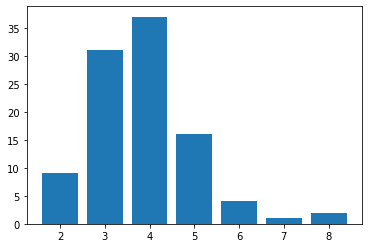

In [13]:
print(np.mean(scores))
plt.bar(*np.unique(scores, return_counts = True))
plt.show()

On average, `random_check_yellows` scores around 4 guesses, which is in line with an average human player. But the bot has an unfair advantage  by knowing the set of all possible answers at all times. What if we make it choose from all ~13000 possible guesses?

In [17]:
def random_all_check_yellows(patterns):
    guess = random.choice([word for word in valid_guesses if np.all([pattern_match(word, pattern) for pattern in patterns])])
    
    while not moves_yellows(guess, patterns):
        guess = random_answers_every_guess(patterns)
        
    return guess

Not only is the runtime for each game much slower, since more possible guesses need to be checked, but the performance is also a little bit worse. For every turn in each game, the program has to check the pattern against all of the possible guesses for every pattern that has been collected so far in that game. Perhaps there is a faster way to narrow down the selection?

### Speeding up the search

This function dramatically speeds up the pattern matching process by using regular expressions, which are constructed in the following way:

1. Build three sets of characters, one for each color.
    * Greys get excluded everywhere
    * Yellows get excluded in a specific location
    * Greens become required at that location
2. Build a regular expression one character at a time (out of the five in the candidate words) in the following way:
    * If the character in this location is known (i.e. green), add that character to the regular expression
    * Otherwise, use the `[]` operator in conjunction with `^` to exclude every grey character in addition to the yellow characters that appeared in that location.
    
The flattened `patterns` array preserves the original order, so the applicable position in the regular expression can be found by taking the index mod 5.

The corpus of choice is then searched using the regular expression, and a list of all matches is made. But there is one missing piece: no part of our regular expression mandates the existence of any yellow letter in a *different* part of the string. A final check is made on all of the matches to make sure that they fit these criteria.
    

In [39]:
def match_all_patterns(patterns, corpus):
    # Convert the patterns into a 2-d array.
    #    The first element is an array with all of the letters, and
    #    the seconds is the corresponding value. Order is preserved.
    patterns = np.transpose(np.reshape(np.transpose(patterns), (2, -1), order='F'))
    
    # Convert corpus to single string
    if isinstance(corpus, list):
        corpus = "\n".join(list(map(str, corpus)))
        corpus = "\n"+corpus
        

    
    # Initialize exclusion classes
    greys = ""
    yellows = ["","","","",""]
    greens = ["","","","",""]
    
    # Fill the exculsion classes based on the patterns
    for i, (c, val) in enumerate(patterns):
        # The numpy conversions changed the vals to strings
        val = int(val)

        if val == 0:
            greys += c
        elif val == 1:
            yellows[i % 5] += c
        else:
            greens[i % 5] = c
    
    # Build the regular expression from the exclusion classes
    re_string = "(\n)("

    for i in range(5):
        if greens[i] != "":
            re_string += greens[i]
            continue

        re_string += f"[^{greys + yellows[i]}]"
        
    re_string += ")"
        
    try:
        # Search the corpus using the regex (also removes \n)
        match_candidates = re.findall(re_string, corpus)
        
        if len(match_candidates) == 0:
            return []
        
        #match_candidates = list(zip(*re.findall(re_string, corpus)))[1]
    except:
        print("Error for the following patterns: \n")
        print(patterns)
        print("\n")
        print("Here is the corpus being tested: ")
        print(corpus)
        print("Here is the set of regex matches: \n")
        print(re.findall(re_string, corpus))
        
    # remove \n
    match_candidates = list(zip(*match_candidates))[1]
    
    return [candidate for candidate in match_candidates if all(char in candidate for char in "".join(yellows))]

Now let's build a new version of `random_answers_check_yellows` using the new `match_all_patterns` method. This version has roughly the same average score as before, but it now runs about 300 times faster!

In [14]:
def random_answers_fast(patterns):
    matches = match_all_patterns(patterns, answers_no_split)
    
    return random.choice(matches)

get_average_score(random_answers_fast)

100%|██████████| 1000/1000 [00:03<00:00, 265.10it/s]


3.892

###### Plans for the rest of the project:
* Changes/fixes
    * Fix error with duplicate letters
* Add more strategies
    * Word frequency
    * Information gain
* Compare strategies
    * Average score
    * % Solved in $\leq$ 6 guesses
    * Full distributions

In [37]:
def information_matches(patterns):
    matches = match_all_patterns(patterns, answers_no_split)
    
    max_entropy = (0, None)
    
    for match in matches:
        entropy = get_entropy(match, matches)
        if entropy > max_entropy[0]:
            max_entropy = (entropy, match)        
    return max_entropy[1]
        
        
# Here, 'word' represents the word that the corpus is being tested against
def get_entropy(word, corpus):
    sizes = np.empty(len(corpus))
    
    for i, candidate in enumerate(corpus):
        sizes[i] = get_candidate_set_size(word, candidate, corpus)
        
        
    return np.mean(np.log2(sizes))
        
# Figures out how much the solution set is narrowed by guessing 'word' if the solution is 'candidate'
def get_candidate_set_size(word, candidate, corpus):
    if word == candidate:
        return 0
    
    candidate_pattern = generate_pattern(word, candidate)
    size = len(match_all_patterns(candidate_pattern, corpus))
    return size


In [41]:
play_wordle(information_matches, show_pattern=True, show_guess=True)

⬛⬛⬛⬛⬛crane


C:\Users\wpdtj\AppData\Local\Temp\ipykernel_15152\284766292.py:21: RuntimeWarning: divide by zero encountered in log2
  return np.mean(np.log2(sizes))


Error on turn 2: 

⬛⬛⬛⬛⬛crane


False

In [24]:
re.findall(r'decr\w', "\ndecor\ndecry")

['decry']